In [1]:
from imports.sample_io import load_sample
from tqdm import tqdm, trange
events_a = load_sample('a', 1)
events_b = load_sample('b', 4200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


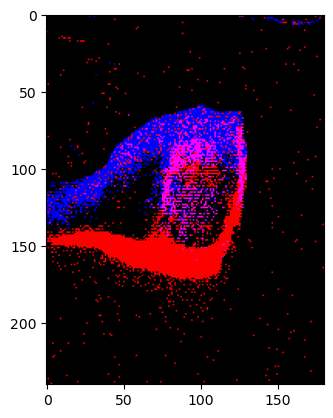

In [2]:
from imports.utils import visualize_frames

visualize_frames(events_a)

In [ ]:
visualize_frames(events_b, start=0, finish=8000)

In [ ]:
from imports.sample_io import load_sample
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

events_a = load_sample('a', 1)
events_a['idx'] = events_a.index
beta = 0.2e-2
events_a['ts'] = beta*events_a['ts']

In [ ]:
melt=events_a[['idx', 'ts', 'x', 'y']].melt(id_vars='idx')
sns.boxplot(data=melt, y='value', x='variable')

In [ ]:
events_b['x'].median() / events_b['ts'].median()

In [ ]:
from imports.ASLDataset import ASLDataset
import torch
#torch.set_default_dtype(torch.float32) 

l = ASLDataset(letters=['a', 'b'], overwrite_processing=False)

In [ ]:
from torch_geometric.loader import DataLoader

dl = DataLoader(l, 10, shuffle=True)

In [1]:
import os.path as osp
import numpy as np
import math
import shutil
import os

import torch
from torch.utils.data.dataset import Subset
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import SplineConv, voxel_grid, max_pool, max_pool_x, graclus




transform = T.Cartesian(cat=False)



class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(1, 64, dim=3, kernel_size=5)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = SplineConv(64, 128, dim=3, kernel_size=5)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = SplineConv(128, 256, dim=3, kernel_size=5)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.conv4 = SplineConv(256, 512, dim=3, kernel_size=5)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.fc1 = torch.nn.Linear(64 * 512, 1024)
        self.fc2 = torch.nn.Linear(1024, 2)

    def forward(self, data):
        inp = self.conv1(data.x, data.edge_index, data.edge_attr)
        data.x = F.elu(inp)
        data.x = self.bn1(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=[4,4])
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn2(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=[6,6])
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))
        
        data.x = F.elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn3(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=[20,20])
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv4(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn4(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=[32,32])
        x, _ = max_pool_x(cluster, data.x, data.batch, size=64)

        x = x.view(-1, self.fc1.weight.size(1))
        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


def train(epoch, train_loader):
    model.train()

    if epoch == 60:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    if epoch == 110:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001

    for i, data in enumerate(tqdm(train_loader, desc='batches')):
        with autograd.detect_anomaly():
            data = data.to(device)
            #print(data.y)
            optimizer.zero_grad()
            end_point = model(data)
            
            loss = F.nll_loss(end_point, data.y)
            pred = end_point.max(1)[1]
            acc = (pred.eq(data.y).sum().item())/len(data.y)
            
            loss.backward()
            optimizer.step()
            
            if i % 10 == 0:
                print({'epoch': epoch,'batch': i + 1,'loss': loss.item(),'acc': acc})

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
print(device)
#model = torch.load('./runs_model/model.pkl')
#model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda


In [3]:
model.train()

Net(
  (conv1): SplineConv(1, 64, dim=3)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SplineConv(64, 128, dim=3)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SplineConv(128, 256, dim=3)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): SplineConv(256, 512, dim=3)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

for epoch in range(1, 150):
    
    train_data_aug = T.Compose([T.Cartesian(cat=False), T.RandomFlip(axis=0, p=0.3), T.RandomScale([0.95,0.999]), T.RandomFlip(axis=1, p=0.2)])
    train_loader = dl
    
    train(epoch, train_loader)

In [1]:
import torch
model = torch.load('model.pkl')
model

Net(
  (conv1): SplineConv(1, 64, dim=3)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SplineConv(64, 128, dim=3)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SplineConv(128, 256, dim=3)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): SplineConv(256, 512, dim=3)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [5]:
import pandas as pd

log = pd.read_csv('log', names = ['epoch', 'batch', 'loss', 'acc'])
log

,epoch,batch,loss,acc
0,1,1,0.810928,0.400000
1,1,2,2.236986,0.333333
2,1,3,2.274865,0.466667
3,1,4,1.074242,0.666667
4,1,5,1.757672,0.333333
...,...,...,...,...
6267,14,444,0.715782,0.533333
6268,14,445,0.758298,0.400000
6269,14,446,0.773927,0.466667
6270,14,447,0.715164,0.666667


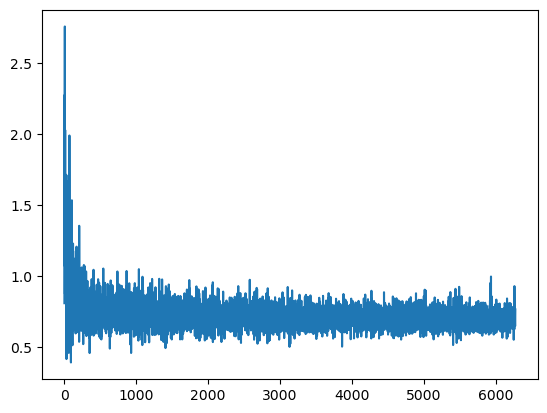

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.plot(log['loss'])

<AxesSubplot:ylabel='loss'>

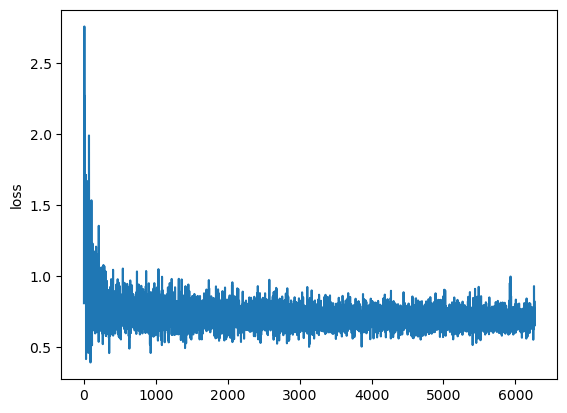

In [10]:
sns.lineplot(x=log.index, y=log['loss'], )